In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Read the CSV file into a DataFrame
dgl_16 = pd.read_csv('dgl_k16.csv', sep=',', header=None)
dgl_16.columns = ['time', 'model', 'nodes', 'vertices', 'features', 'density', 'runtime', 'method', 'bs']

dgl_128 = pd.read_csv('dgl_k128.csv', sep=',', header=None)
dgl_128.columns = ['time', 'model', 'nodes', 'vertices', 'features', 'density', 'runtime', 'method', 'bs']

dgl = pd.concat([dgl_16, dgl_128], ignore_index=True)
dgl['model'] = dgl['model'].str.upper()
# dgl = dgl[dgl['method'].isin(['NORM', 'DIST_SAMPLE'])]
dgl = dgl[dgl['method'].isin(['DIST_SAMPLE'])]
dgl['edges'] = (dgl['vertices'] * dgl['vertices'] * dgl['density']).astype(int)
# replace_dgl = {171798691: 171798692, 109951162: 109951163} # hack
# dgl['edges'] = dgl['edges'].replace(replace_dgl)
dgl['method'] = dgl['method'].replace({'NORM': 'DGL Single', 'DIST_SAMPLE': 'DistDGL'})
dgl.drop(columns=['time', 'bs'], inplace=True)

dgl

,model,nodes,vertices,features,density,runtime,method,edges
2,AGNN,1,1048576,16,0.0001,35.518624,DistDGL,109951162
5,GAT,1,1048576,16,0.0001,35.338995,DistDGL,109951162
8,VA,1,1048576,16,0.0001,35.113917,DistDGL,109951162
11,AGNN,1,131072,16,0.0010,2.076247,DistDGL,17179869
14,GAT,1,131072,16,0.0010,2.033473,DistDGL,17179869
...,...,...,...,...,...,...,...,...
623,GAT,16,262144,128,0.0001,0.510980,DistDGL,6871947
625,VA,16,262144,128,0.0001,0.331471,DistDGL,6871947
627,AGNN,16,131072,128,0.0001,0.225811,DistDGL,1717986
629,GAT,16,131072,128,0.0001,0.280436,DistDGL,1717986


In [2]:
print(dgl['vertices'].unique())
print(dgl['density'].unique())
print(dgl['edges'].unique())

[1048576  131072  262144  524288]
[0.0001 0.001  0.01  ]
[ 109951162   17179869    6871947  171798691  274877906  687194767
   27487790   68719476    1717986 2748779069]


In [3]:

ours = pd.read_csv('weak.csv', sep='\t', header=None)
ours.columns = ['model', 'task', 'nodes', 'dtype', 'vertices', 'edges', 'layers', 'features', 'runtime', 'std']
ours['method'] = 'Ours Dist'
ours['model'] = ours['model'].replace({'unified_distr_VA': 'VA', 'unified_distr_GAT': 'GAT', 'unified_distr_AGNN': 'AGNN'})

ours['runtime'] = ours['runtime'] / 1e3 # ms to s
ours = ours[ours['task'] == 'training']
ours.drop(columns=['task','std', 'dtype', 'layers'], inplace=True)

ours['density'] = (ours['edges'] / (ours['vertices'] * ours['vertices'])).apply(lambda x: round(x, 1 - int(math.floor(math.log10(abs(x))))))

ours

,model,nodes,vertices,edges,features,runtime,method,density
3,VA,1,131072,1717987,16,0.265,Ours Dist,0.0001
8,VA,4,262144,6871948,16,0.339,Ours Dist,0.0001
13,VA,16,524288,27487791,16,0.372,Ours Dist,0.0001
15,VA,1,131072,17179869,16,0.657,Ours Dist,0.0010
16,VA,4,262144,68719477,16,0.740,Ours Dist,0.0010
...,...,...,...,...,...,...,...,...
174,AGNN,256,2097152,43980465111,16,2.817,Ours Dist,0.0100
175,AGNN,256,2097152,4398046511,128,6.190,Ours Dist,0.0010
177,VA,256,2097152,43980465111,128,10.807,Ours Dist,0.0100
178,GAT,256,2097152,43980465111,128,15.616,Ours Dist,0.0100


In [9]:
def calculate_efficiency(group):
    # Get the runtime of node==1 within the group
    runtime_node1 = group.loc[group['nodes'] == 1, 'runtime'].values[0]
    # Calculate the efficiency by dividing the 'runtime' column by the 'runtime' of node==1 within the group
    group['efficiency'] = runtime_node1 / group['runtime'] * 100
    return group

# Group the DataFrame by 'density' and 'features' columns and apply the custom function
df = ours.groupby(['density', 'features', 'model']).apply(calculate_efficiency)

pd.set_option('display.max_rows', None)
# Print the modified DataFrame
df

model  nodes  vertices        edges  features   
density features model                                                     
0.0001  16       AGNN  48   AGNN      1    131072      1717987        16  \
                       50   AGNN      4    262144      6871948        16   
                       55   AGNN     16    524288     27487791        16   
                       71   AGNN     64   1048576    109951163        16   
                       121  AGNN    256   2097152    439804651        16   
                 GAT   36    GAT      1    131072      1717987        16   
                       37    GAT      4    262144      6871948        16   
                       38    GAT     16    524288     27487791        16   
                       67    GAT     64   1048576    109951163        16   
                       120   GAT    256   2097152    439804651        16   
                 VA    3      VA      1    131072      1717987        16   
                       8      VA      4    262144      6871948        16   
                       13     VA     16    524288     27487791        16   
                       18     VA     64   1048576    109951163        16   
                       105    VA    256   2097152    439804651        16   
        128      AGNN  136  AGNN      1    131072      1717987       128   
                       138  AGNN      4    262144      6871948       128   
                       149  AGNN     16    524288     27487791       128   
                       153  AGNN     64   1048576    109951163       128   
                       172  AGNN    256   2097152    439804651       128   
                 GAT   66    GAT      1    131072      1717987       128   
                       94    GAT      4    262144      6871948       128   
                       125   GAT     16    524288     27487791       128   
                       129   GAT     64   1048576    109951163       128   
                       170   GAT    256   2097152    439804651       128   
                 VA    52     VA      1    131072      1717987       128   
                       69     VA      4    262144      6871948       128   
                       72     VA     16    524288     27487791       128   
                       97     VA     64   1048576    109951163       128   
                       165    VA    256   2097152    439804651       128   
0.0010  16       AGNN  57   AGNN      1    131072     17179869        16   
                       61   AGNN      4    262144     68719477        16   
                       62   AGNN     16    524288    274877907        16   
                       86   AGNN     64   1048576   1099511628        16   
                       126  AGNN    256   2097152   4398046511        16   
                 GAT   47    GAT      1    131072     17179869        16   
                       51    GAT      4    262144     68719477        16   
                       63    GAT     16    524288    274877907        16   
                       85    GAT     64   1048576   1099511628        16   
                       123   GAT    256   2097152   4398046511        16   
                 VA    15     VA      1    131072     17179869        16   
                       16     VA      4    262144     68719477        16   
                       19     VA     16    524288    274877907        16   
                       21     VA     64   1048576   1099511628        16   
                       106    VA    256   2097152   4398046511        16   
        128      AGNN  143  AGNN      1    131072     17179869       128   
                       145  AGNN      4    262144     68719477       128   
                       151  AGNN     16    524288    274877907       128   
                       155  AGNN     64   1048576   1099511628       128   
                       175  AGNN    256   2097152   4398046511       128   
                 GAT   80    GAT      1    131072     17179869       128   

In [88]:
print(ours['vertices'].unique())
print(ours['density'].unique())
print(ours['edges'].unique())

[ 131072  262144  524288 1048576 2097152]
[0.0001 0.001  0.01  ]
[    1717987     6871948    27487791    17179869    68719477   109951163
   274877907  1099511628   171798692   687194767  2748779069 10995116278
   439804651  4398046511 43980465111]


In [89]:
data = pd.concat([dgl, ours], ignore_index=True)
data

,model,nodes,vertices,features,density,runtime,method,edges
0,AGNN,1,1048576,16,0.0001,35.518624,DistDGL,109951162
1,GAT,1,1048576,16,0.0001,35.338995,DistDGL,109951162
2,VA,1,1048576,16,0.0001,35.113917,DistDGL,109951162
3,AGNN,1,131072,16,0.0010,2.076247,DistDGL,17179869
4,GAT,1,131072,16,0.0010,2.033473,DistDGL,17179869
...,...,...,...,...,...,...,...,...
388,AGNN,256,2097152,16,0.0100,2.817000,Ours Dist,43980465111
389,AGNN,256,2097152,128,0.0010,6.190000,Ours Dist,4398046511
390,VA,256,2097152,128,0.0100,10.807000,Ours Dist,43980465111
391,GAT,256,2097152,128,0.0100,15.616000,Ours Dist,43980465111


In [90]:
vertices = [131072, 262144, 524288, 1048576, 2097152]
densities = [0.0001, 0.001, 0.01]
combination = [(1, 131072),
               (4, 262144),
               (16, 524288),
               (64, 1048576),
               (256, 2097152)]
def get_col_mar_lst_mfc(algo, model):
	col = "#000000"
	mar = "*"
	lst = "-"
	mfc = "none"

	# Color, Marker
	if model == "GAT":
		col = "#009900"
		mar = "o"
	if model == "VA":
		col = "#990000"
		mar = "d"
	if model == "AGNN":
		col = "#000099"
		mar = "s"

	# Line-style
	if algo == "Ours Single":
		lst = "none"
		mfc = col
	if algo == "Ours Dist":
		lst = "-"
	if algo == "DGL Single":
		lst = "none"
		mfc = col
	if algo == "DistDGL":
		lst = "--"

	return (col, mar, lst, mfc)

  model  nodes  vertices  features  density   method     edges   runtime
0  AGNN      1    131072        16   0.0001  DistDGL   1717986  1.496078
1  AGNN      4    262144        16   0.0001  DistDGL   6871947  1.095815
2  AGNN     16    524288        16   0.0001  DistDGL  27487790  0.852777
  model  nodes  vertices  features  density   method     edges   runtime
0   GAT      1    131072        16   0.0001  DistDGL   1717986  1.484092
1   GAT      4    262144        16   0.0001  DistDGL   6871947  1.156973
2   GAT     16    524288        16   0.0001  DistDGL  27487790  1.015731
  model  nodes  vertices  features  density   method     edges   runtime
0    VA      1    131072        16   0.0001  DistDGL   1717986  1.479089
1    VA      4    262144        16   0.0001  DistDGL   6871947  1.141861
2    VA     16    524288        16   0.0001  DistDGL  27487790  0.847702
  model  nodes  vertices  features  density     method      edges  runtime
0    VA      1    131072        16   0.0001  Ours

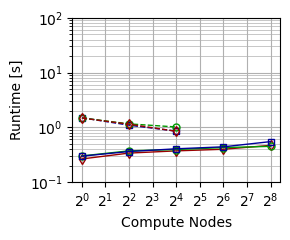

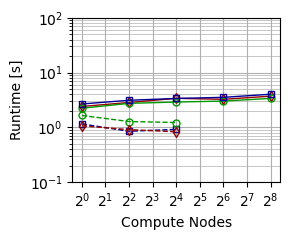

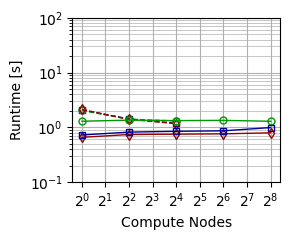

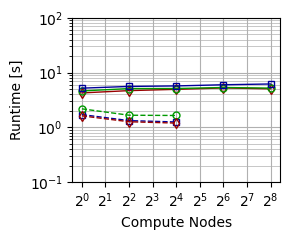

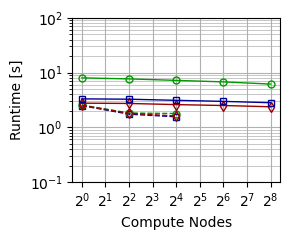

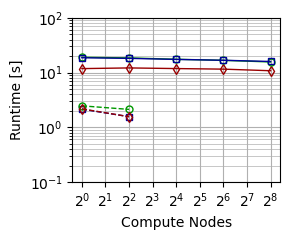

In [91]:

for d in densities:
    for feats in [16, 128]:
        fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
        for method in data['method'].unique():
            curr_method = data[data['method'] == method]
            for model in curr_method['model'].unique():
                curr_model = curr_method[curr_method['model'] == model]
                cur_data = curr_model[(curr_model['density'] == d) & (curr_model['features'] == feats)].sort_values(by=['nodes'])
                # only select (nodes, density) in combination
                cur_data = cur_data[cur_data[['nodes', 'vertices']].apply(tuple, axis=1).isin(combination)]
                # replace duplicated data with median value
                cur_data = cur_data.groupby(cur_data.columns.drop('runtime').tolist()).max().reset_index()
                print(cur_data)
                col, mar, lst, mfc = get_col_mar_lst_mfc(method, model)
                ax.plot(cur_data['nodes'], cur_data['runtime'], label=model, color=col, marker=mar, linestyle=lst, markerfacecolor=mfc, markersize=5, linewidth=1)

        ax.grid(which = "major")
        ax.grid(which = "minor", linewidth = 0.5)
        # Configure x-axis
        ax.set_xscale("log", base = 2)
        ax.set_xlabel("Compute Nodes")
        ax.set_xticks([2**x for x in range(9)])
        # Configure y-axis
        ax.set_yscale("log", base = 10)
        ax.set_ylabel("Runtime [s]")
        ax.set_ylim([1e-1, 1e2])
        plt.tight_layout()
        plt.savefig("kronecker_weak_scaling_%g_%d.pdf" % (d, feats))

/tmp/ipykernel_1872/3890868008.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


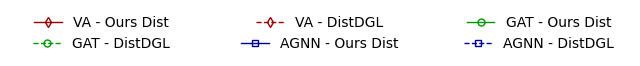

In [94]:
# for global legend
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import itertools
models = ['VA', 'GAT', 'AGNN']
methods = ['Ours Dist', 'DistDGL']

legend_handles = []
for model, method in itertools.product(models, methods):
    label = model + ' - ' + method
    col, mar, lst, mfc = get_col_mar_lst_mfc(method, model)
    legend_handles.append(Line2D([], [], color=col, marker=mar, linestyle=lst, markerfacecolor=mfc, markersize=5, linewidth=1, label=label))

# Create a figure with multiple axes for legends
fig, axes = plt.subplots(2, 3, figsize=(8, 0.5))
axes = axes.flatten()

# Iterate over the axes and add legends
for ax, handle in zip(axes, legend_handles):
    ax.axis('off')  # Remove axes and ticks
    ax.legend(handles=[handle], frameon=False, loc='center')

# Show the figure
plt.tight_layout()
plt.savefig("global_legend.pdf")